# Индекс качества интернета в ЦФО России

**Структура исследования:**

 - открытие данных;
 - изучение данных;
 - фильтрация данных;
 - преобразование данных;
 - исследование данных по регионам
 - составление итогового индекса;
 - формулирование выводов;

In [176]:
import geopandas as gpd
import numpy as np
import pandas as pd
import fiona
import seaborn as sns
import h3
import h3pandas
from shapely.geometry import Polygon

In [177]:
pd.options.display.max_rows = 100

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

## Данные

### Источник

https://registry.opendata.aws/speedtest-global-performance/

Speedtest by Ookla Global Fixed and Mobile Network Performance Maps was accessed on DATE from https://registry.opendata.aws/speedtest-global-performance. Speedtest® by Ookla® Global Fixed and Mobile Network Performance Maps. Based on analysis by Ookla of Speedtest Intelligence® data for 2020-01-01 - 2020-04-01. Provided by Ookla and accessed 2020-04-01. Ookla trademarks used under license and reprinted with permission.

**Описание:**

Глобальная производительность фиксированной широкополосной, с пространственным разрешением примерно 610,8 на 610,8. Скорость скачивания, скорость загрузки и задержка собираются с помощью приложений Speedtest от Ookla для Android и iOS и усредняются для каждой плитки. Измерения фильтруются для результатов, содержащих точность определения местоположения с качеством GPS.

**Период:**
    
С 2020-01-01 по 2020-04-01

### Открытие данных

 - avg_d_kbps - скорость скачивания (кбит/с);
 - avg_u_kbps - скорость загрузки (кбит/с);
 - avg_lat_ms - задержка (мс);
 - tests - количество тестов;
 - devices - количество устройств;

In [179]:
st_fix_df= gpd.read_file(f"st_fixed_cfo.geojson")\
    .drop('region', axis = 1)\
    .rename(columns={'name_2': "region"})\

st_fix_df.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,osm_id,fclass,name,federal_district,region,geometry
0,1203101110112210,49535,52315,5,6,3,22917514,town,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794)
1,1203101110112211,43133,79748,6,7,4,22917514,town,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73794)
2,1203101110112213,74030,97632,6,15,6,22917514,town,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73484)
3,1203101110112220,57186,73459,7,7,3,22917514,town,Ликино-Дулёво,Центральный,Московская область,POINT (38.93829 55.73175)
4,1203101110112230,81151,86821,6,4,3,22917514,town,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73175)


In [180]:
st_fix_df.shape

(28235, 12)

In [181]:
st_fix_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 28235 entries, 0 to 28234
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   quadkey           28235 non-null  object  
 1   avg_d_kbps        28235 non-null  int64   
 2   avg_u_kbps        28235 non-null  int64   
 3   avg_lat_ms        28235 non-null  int64   
 4   tests             28235 non-null  int64   
 5   devices           28235 non-null  int64   
 6   osm_id            18684 non-null  object  
 7   fclass            19865 non-null  object  
 8   name              19865 non-null  object  
 9   federal_district  18684 non-null  object  
 10  region            28235 non-null  object  
 11  geometry          28235 non-null  geometry
dtypes: geometry(1), int64(5), object(6)
memory usage: 2.6+ MB


**Вывод:**
таблица st_fix_df имеет размер 28235 строк и 12 столбцов.

### Границы регионов ЦФО

In [182]:
#границы регионов ЦФО
cfo_gdf= gpd.read_file(f"E:/arch_projects/71_Speedtest/02_process/shp/cfo_pm_sim.geojson")\

cfo_gdf['label_name'] = cfo_gdf['ref'].str.slice(start=3)

cfo_gdf.head(3)

,ref,name,label_name,geometry
0,RU-VLA,Владимирская область,VLA,"MULTIPOLYGON (((4652349.129 7381574.599, 46511..."
1,RU-TVE,Тверская область,TVE,"MULTIPOLYGON (((4257335.857 7718021.024, 42580..."
2,RU-KLU,Калужская область,KLU,"MULTIPOLYGON (((4148733.720 7331223.347, 41471..."


## Предобработка

In [183]:
#переводим из кбит/с в Мбит/с
st_fix_df['avg_d_mbps'] = round(st_fix_df['avg_d_kbps']/1000,2)
st_fix_df['avg_u_mbps'] = round(st_fix_df['avg_u_kbps']/1000,2)

In [184]:
## классифицируем сетку на городской и сельский тип
def fclass_type(row):
    
    if row != None:  
        return 'city'
    
    else: 
        return 'village'
    
st_fix_df['fclass'] = st_fix_df['name'].apply(fclass_type)

st_fix_df.head(1)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,osm_id,fclass,name,federal_district,region,geometry,avg_d_mbps,avg_u_mbps
0,1203101110112210,49535,52315,5,6,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794),49.54,52.32


## Исследовательский анализ

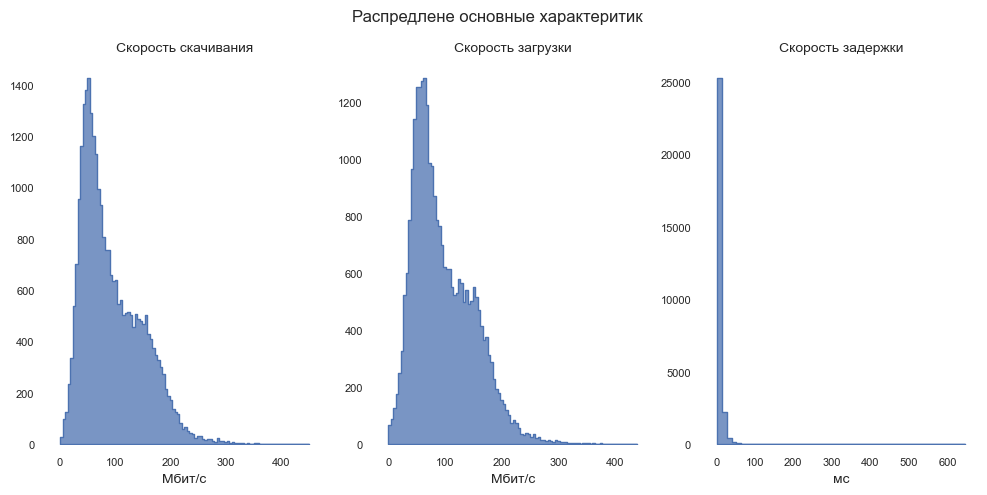

In [185]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

sns.despine(bottom=True, left=True)

fig.suptitle("Распредлене основные характеритик", fontsize=12)

sns.histplot(data=st_fix_df, x="avg_d_mbps", bins = 100, element="step", ax = axs[0])
axs[0].set_xlabel('Мбит/с', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].tick_params(labelsize=8)
axs[0].set_title("Скорость скачивания", fontsize=10)

sns.histplot(data=st_fix_df, x="avg_u_mbps", bins = 100, element="step", ax = axs[1])
axs[1].set_xlabel('Мбит/с', fontsize=10)
axs[1].set_ylabel('', fontsize=10)
axs[1].tick_params(labelsize=8)
axs[1].set_title("Скорость загрузки", fontsize=10)

sns.histplot(data=st_fix_df, x="avg_lat_ms", bins = 50, element="step", ax = axs[2])
axs[2].set_xlabel('мс', fontsize=10)
axs[2].set_ylabel('', fontsize=10)
axs[2].tick_params(labelsize=8)
axs[2].set_title("Скорость задержки", fontsize=10)

plt.show()

## Фильтрация данных

In [186]:
## отфильтруем данные по 99-у перцентилю с минимальным количеством девайсов равным 3
st_fix_df_f = st_fix_df\
    .loc[st_fix_df['devices'] >= 3]\
    .loc[(st_fix_df['avg_d_kbps'] <= st_fix_df['avg_d_kbps'].quantile(0.99))]\
    .loc[(st_fix_df['avg_u_kbps'] <= st_fix_df['avg_u_kbps'].quantile(0.99))]\
    .loc[st_fix_df['avg_lat_ms'] <= st_fix_df['avg_lat_ms'].quantile(0.99)]\

st_fix_df_f.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,osm_id,fclass,name,federal_district,region,geometry,avg_d_mbps,avg_u_mbps
0,1203101110112210,49535,52315,5,6,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794),49.54,52.32
1,1203101110112211,43133,79748,6,7,4,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73794),43.13,79.75
2,1203101110112213,74030,97632,6,15,6,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73484),74.03,97.63
3,1203101110112220,57186,73459,7,7,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.93829 55.73175),57.19,73.46
4,1203101110112230,81151,86821,6,4,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73175),81.15,86.82


In [187]:
st_fix_df_f.shape

(27568, 14)

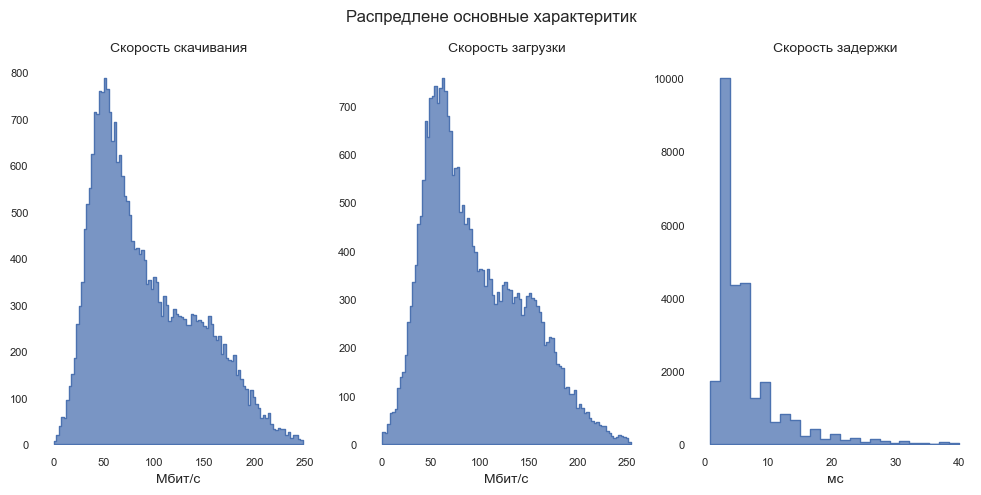

In [188]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

sns.despine(bottom=True, left=True)

fig.suptitle("Распредлене основные характеритик", fontsize=12)

sns.histplot(data=st_fix_df_f, x="avg_d_mbps", bins = 100, element="step", ax = axs[0])
axs[0].set_xlabel('Мбит/с', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].tick_params(labelsize=8)
axs[0].set_title("Скорость скачивания", fontsize=10)

sns.histplot(data=st_fix_df_f, x="avg_u_mbps", bins = 100, element="step", ax = axs[1])
axs[1].set_xlabel('Мбит/с', fontsize=10)
axs[1].set_ylabel('', fontsize=10)
axs[1].tick_params(labelsize=8)
axs[1].set_title("Скорость загрузки", fontsize=10)

sns.histplot(data=st_fix_df_f, x="avg_lat_ms", bins = 25, element="step", ax = axs[2])
axs[2].set_xlabel('мс', fontsize=10)
axs[2].set_ylabel('', fontsize=10)
axs[2].tick_params(labelsize=8)
axs[2].set_title("Скорость задержки", fontsize=10)

plt.show()

**Вывод:**
После фильтрации таблица st_fix_df_f имеет размер 27568, сокращение размера на 2,4%;

## Преобразование

Для корректных расчётов средних значений нам нужно взвесить характеристики на количество девайсов в квадрате, для этого воспользуемся функцией explode

In [189]:
def tests_lst_generate(row):
    
    return [i for i in range(1,row+1)]
    
st_fix_df_f['devices_lst'] = st_fix_df_f['devices'].apply(tests_lst_generate)

In [190]:
st_fix_df_exp = st_fix_df_f\
    .explode('devices_lst')\
    .reset_index()

st_fix_df_exp.head(5)

,index,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,osm_id,fclass,name,federal_district,region,geometry,avg_d_mbps,avg_u_mbps,devices_lst
0,0,1203101110112210,49535,52315,5,6,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794),49.54,52.32,1
1,0,1203101110112210,49535,52315,5,6,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794),49.54,52.32,2
2,0,1203101110112210,49535,52315,5,6,3,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.94928 55.73794),49.54,52.32,3
3,1,1203101110112211,43133,79748,6,7,4,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73794),43.13,79.75,1
4,1,1203101110112211,43133,79748,6,7,4,22917514,city,Ликино-Дулёво,Центральный,Московская область,POINT (38.95477 55.73794),43.13,79.75,2


In [191]:
st_fix_df_exp.shape

(401713, 16)

**Вывод:**
После обработки таблица st_fix_df_exp имеет размер 401713 строк, увеличение размера в 15 раз;

## Расчёт индекса. Регионы.

### Скачивание. Загрузка. Задержка.

In [192]:
st_by_regions = st_fix_df_exp\
    .groupby('region')\
    .agg({'avg_d_mbps':'median', 'avg_u_mbps':'median', 'avg_lat_ms':'median', 'devices':'count'})\
    .reset_index()\
    .sort_values(by = ['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], ascending = [False, False, True])\
    .merge(cfo_gdf,  left_on='region', right_on='name')\
    .drop('name', axis = 1)


st_by_regions_gdf = gpd.GeoDataFrame(st_by_regions, geometry='geometry')

st_by_regions_gdf.head(5)  

,region,avg_d_mbps,avg_u_mbps,avg_lat_ms,devices,ref,label_name,geometry
0,Москва,157.38,153.60,4.0,184647,RU-MOW,MOW,"MULTIPOLYGON (((4218984.790 7521900.345, 42172..."
1,Московская область,98.43,105.73,5.0,120064,RU-MOS,MOS,"MULTIPOLYGON (((4304277.405 7218925.548, 43034..."
2,Воронежская область,94.04,97.04,6.0,15277,RU-VOR,VOR,"MULTIPOLYGON (((4361491.248 6427040.548, 43612..."
3,Брянская область,91.97,96.47,3.0,4167,RU-BRY,BRY,"MULTIPOLYGON (((3515650.747 6886733.181, 35151..."
4,Рязанская область,87.01,93.30,5.0,6913,RU-RYA,RYA,"MULTIPOLYGON (((4732093.247 7313928.400, 47303..."


#### avg_d_mbps

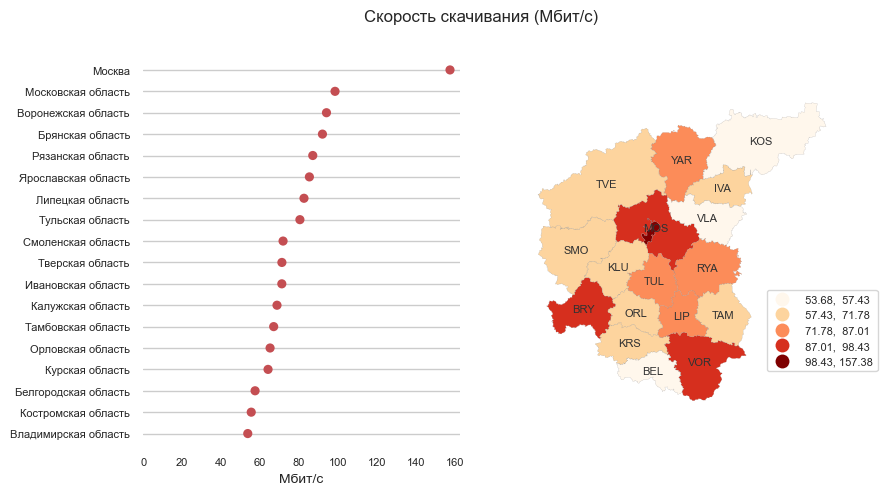

In [193]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_d = st_by_regions_gdf\
        .sort_values(by = 'avg_d_mbps', ascending = False)\

fig.suptitle("Скорость скачивания (Мбит/с)", fontsize=12)
sns.pointplot(
    data=reg_d, x="avg_d_mbps", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'r',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('Мбит/с', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_d.plot(column="avg_d_mbps", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_d\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232', 
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наибольшие значения скорости скачивания имеет Московский регион (до 157 Мбит/с). Наименьшие значения во Владимирской и Костромской областях (от 54 Мбит/с);

#### avg_u_mbps

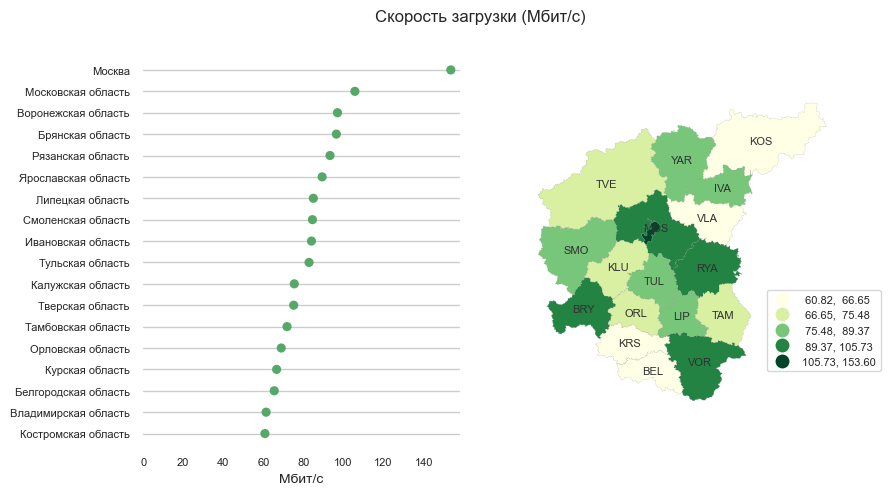

In [194]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_u = st_by_regions_gdf\
        .sort_values(by = 'avg_u_mbps', ascending = False)\

fig.suptitle("Скорость загрузки (Мбит/с)", fontsize=12)

sns.pointplot(
    data=reg_u, x="avg_u_mbps", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'g',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('Мбит/с', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_u.plot(column="avg_u_mbps", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='YlGn', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_u\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232', 
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наибольшие значения скорости загрузки имеет Московский регион(до 154 Мбит/с). Наименьшие значения во Владимирской и Костромской областях (от 61  Мбит/с);

#### avg_lat_ms

In [195]:
import matplotlib.patheffects as pe

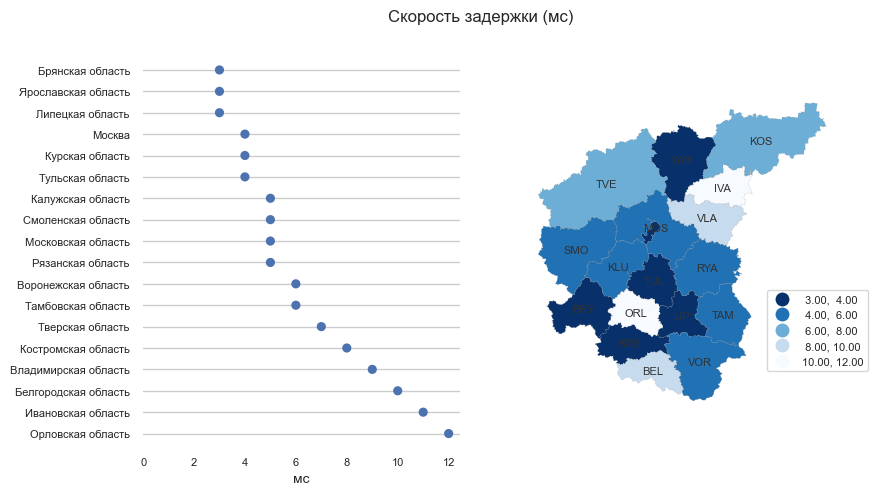

In [196]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_lat = st_by_regions_gdf\
        .sort_values(by = 'avg_lat_ms', ascending = True)\

fig.suptitle("Скорость задержки (мс)", fontsize=12)
sns.pointplot(
    data=reg_lat, x="avg_lat_ms", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'b',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('мс', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_lat.plot(column="avg_lat_ms", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='Blues_r', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_lat\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232',
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наилучшие значения задержки имеет  Брянская, Ярославская и Липецкая области (3 мс). Нихудшие значения в Орловской и Ивановской областях (до 12 мс);

### Индекс неравенства

Просто рассчитать средние параметры по регионам нам не достаточно. Нужно узнать как сильно различаются характеристи внутри каждого региона. Рассчитаем эти значения:

In [197]:
data_all = []
col_list = []

for reg_name in st_fix_df_exp['region'].unique():
    
        df_reg = st_fix_df_exp\
            .loc[st_fix_df_exp['region'] == reg_name]\
        
        dev_d = df_reg['avg_d_kbps'].describe()[2]/df_reg['avg_d_kbps'].describe()[5]
        dev_u = df_reg['avg_u_kbps'].describe()[2]/df_reg['avg_u_kbps'].describe()[5]
        dev_lat = df_reg['avg_lat_ms'].describe()[2]/df_reg['avg_lat_ms'].describe()[5]
        
        col_list.append(reg_name)
        col_list.append(dev_d)
        col_list.append(dev_u)
        col_list.append(dev_lat)
        
        data_all.append(col_list)
        
        col_list = []
        
dev_df = pd.DataFrame(data=data_all, columns=['region', 'dev_d', 'dev_u', 'dev_lat'])\
    .merge(cfo_gdf,  left_on='region', right_on='name')\
    .drop('name', axis = 1)


dev_df_gdf = gpd.GeoDataFrame(dev_df, geometry='geometry')

dev_df_gdf.head(20) 

,region,dev_d,dev_u,dev_lat,ref,label_name,geometry
0,Московская область,0.416028,0.403783,0.643255,RU-MOS,MOS,"MULTIPOLYGON (((4304277.405 7218925.548, 43034..."
1,Рязанская область,0.412785,0.393884,0.698293,RU-RYA,RYA,"MULTIPOLYGON (((4732093.247 7313928.400, 47303..."
2,Липецкая область,0.405854,0.366215,1.298586,RU-LIP,LIP,"MULTIPOLYGON (((4512239.836 6790311.876, 45093..."
3,Тамбовская область,0.616505,0.540128,1.075645,RU-TAM,TAM,"MULTIPOLYGON (((4733400.628 6727425.945, 47309..."
4,Воронежская область,0.372896,0.359590,0.838759,RU-VOR,VOR,"MULTIPOLYGON (((4361491.248 6427040.548, 43612..."
5,Владимирская область,0.574359,0.526094,0.715835,RU-VLA,VLA,"MULTIPOLYGON (((4652349.129 7381574.599, 46511..."
6,Тверская область,0.484690,0.433989,0.688035,RU-TVE,TVE,"MULTIPOLYGON (((4257335.857 7718021.024, 42580..."
7,Курская область,0.422102,0.426171,1.150723,RU-KRS,KRS,"MULTIPOLYGON (((4262265.685 6673883.256, 42605..."
8,Орловская область,0.435327,0.358978,0.480479,RU-ORL,ORL,"MULTIPOLYGON (((4200978.784 6803576.876, 42009..."
9,Тульская область,0.501016,0.465034,1.141371,RU-TUL,TUL,"MULTIPOLYGON (((4334505.100 7089919.015, 43310..."


#### avg_d_mbps

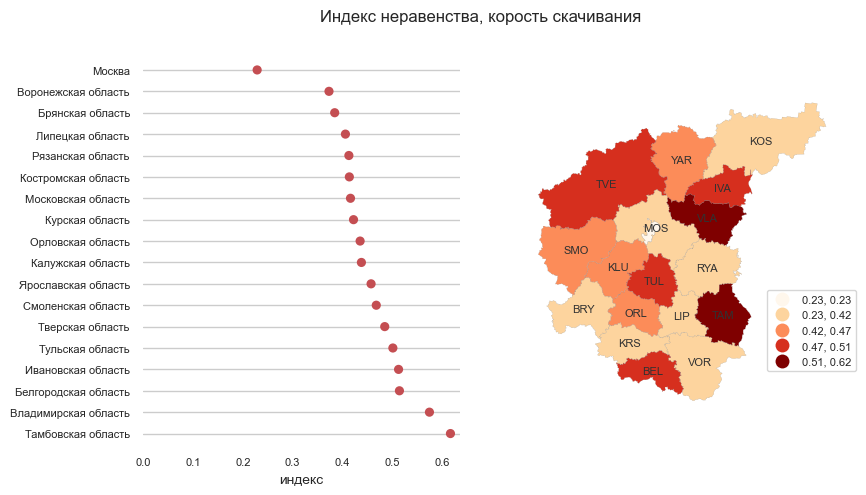

In [198]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_d_dew = dev_df_gdf\
        .sort_values(by = 'dev_d', ascending = True)\

fig.suptitle("Индекс неравенства, cкорость скачивания", fontsize=12)
sns.pointplot(
    data=reg_d_dew, x="dev_d", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'r',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('индекс', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_d_dew.plot(column="dev_d", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_d_dew\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232', 
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наилучшие значения индекса неравенства скорости скачивания имеет Москва (0.22). Наихудшие значения во Владимирской и Тамбовской областях (от 0.62);

#### avg_u_mbps

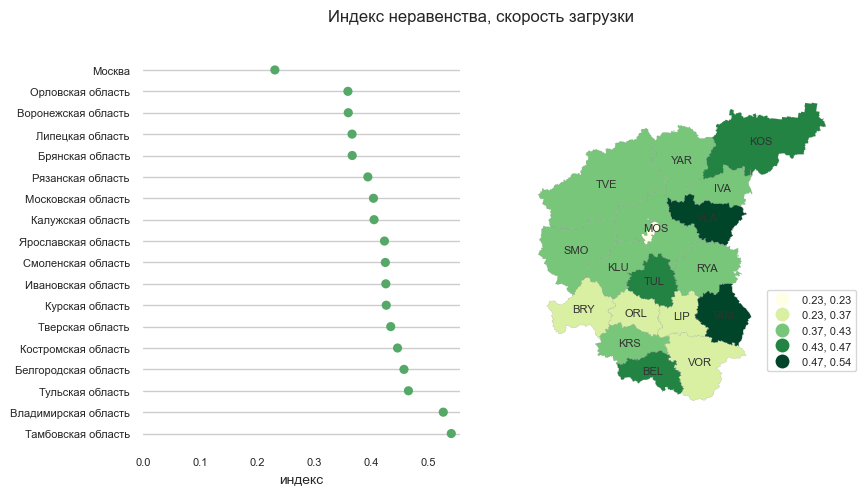

In [199]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_u_dew = dev_df_gdf\
        .sort_values(by = 'dev_u', ascending = True)\

fig.suptitle("Индекс неравенства, скорость загрузки", fontsize=12)

sns.pointplot(
    data=reg_u_dew, x="dev_u", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'g',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('индекс', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_u_dew.plot(column="dev_u", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='YlGn', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_u_dew\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232', 
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наилучшие значения индекса неравенства загрузки имеет Москва (0.23). Наихудшие значения во Владимирской и Тамбовской областях (до 0.54);

#### avg_lat_ms

In [200]:
import matplotlib.patheffects as pe

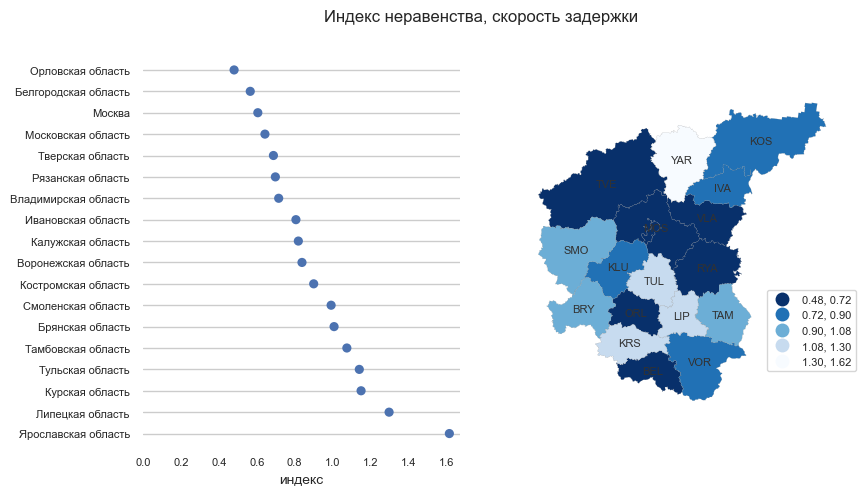

In [201]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

reg_lat_dew = dev_df_gdf\
        .sort_values(by = 'dev_lat', ascending = True)\

fig.suptitle("Индекс неравенства, скорость задержки", fontsize=12)
sns.pointplot(
    data=reg_lat_dew, x="dev_lat", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'b',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('индекс', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

reg_lat_dew.plot(column="dev_lat", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='Blues_r', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

reg_lat_dew\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232',
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:** Наилучшие значения индекса неравенства задержки имеет Орловская область (0.48). Наихудшие значения в Ярославской области (1.62);

## Итоговая таблица

Объединим данные по средним значениям характеристик с данными по равенству характеристик, нормализуем их от 0 до 1. И получим итоговый индекс качества интернета.

**Интерпретация:**

 - avg_d_mbps_n — средняя скорость скачивания (1- максимальное значение, 0 - минимальное);
 - avg_u_mbps_n — средняя скорость загрузки (1- максимальное значение, 0 - минимальное);
 - avg_lat_ms_n — средняя задержка (1- минимальная задержка, 0 - максимальная задержка);
 - dev_d_n — неравенство скорости скачивания (1 - нет неравенства, 0 - есть);
 - dev_u_n — неравенство скорости загрузки (1 - нет неравенства, 0 - есть);
 - dev_lat_n — неравенство задержки (1 - нет неравенства, 0 - есть);
 - total_index — итоговый индекс (1 - нет неравенства, 0 - есть);

In [202]:
import numpy as np
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

index_df = st_by_regions_gdf\
    .merge(dev_df[['region','dev_d', 'dev_u', 'dev_lat',]], on = 'region')

index_df['avg_d_mbps_n'] = min_max_scaler.fit_transform(index_df[['avg_d_mbps']])
index_df['avg_u_mbps_n'] = min_max_scaler.fit_transform(index_df[['avg_u_mbps']])
index_df['avg_lat_ms_n'] = 1 - min_max_scaler.fit_transform(index_df[['avg_lat_ms']])
index_df['dev_d_n'] = 1 - min_max_scaler.fit_transform(index_df[['dev_d']])
index_df['dev_u_n'] = 1 - min_max_scaler.fit_transform(index_df[['dev_u']])
index_df['dev_lat_n'] = 1 - min_max_scaler.fit_transform(index_df[['dev_lat']])


index_df['total_index'] = index_df['avg_d_mbps_n']+index_df['avg_u_mbps_n']+index_df['avg_lat_ms_n']\
    +index_df['dev_d_n']+index_df['dev_u_n']+index_df['dev_lat_n']

index_df.\
    sort_values(by = 'total_index', ascending = False)\
    [['region', 'avg_d_mbps_n', 'avg_u_mbps_n', 'avg_lat_ms_n', 'dev_d_n', 'dev_u_n', 'dev_lat_n', 'total_index']]\
    .head(20)

,region,avg_d_mbps_n,avg_u_mbps_n,avg_lat_ms_n,dev_d_n,dev_u_n,dev_lat_n,total_index
0,Москва,1.000000,1.000000,0.888889,1.000000e+00,1.000000,0.889784,5.778673
1,Московская область,0.431533,0.484048,0.777778,5.171043e-01,0.440984,0.856735,3.508183
3,Брянская область,0.369238,0.384242,1.000000,5.988412e-01,0.561553,0.535559,3.449433
2,Воронежская область,0.389200,0.390386,0.666667,6.283565e-01,0.583919,0.684667,3.343195
4,Рязанская область,0.321408,0.350075,0.777778,5.254689e-01,0.473001,0.808295,3.256026
6,Липецкая область,0.278014,0.260509,1.000000,5.433456e-01,0.562494,0.279959,2.924320
11,Калужская область,0.144552,0.158008,0.777778,4.606750e-01,0.437744,0.701549,2.680306
8,Смоленская область,0.174542,0.255551,0.777778,3.837353e-01,0.373841,0.549285,2.514732
5,Ярославская область,0.304725,0.307717,1.000000,4.106397e-01,0.378734,0.000000,2.401816
9,Тверская область,0.168756,0.154667,0.555556,3.400002e-01,0.343290,0.817324,2.379592


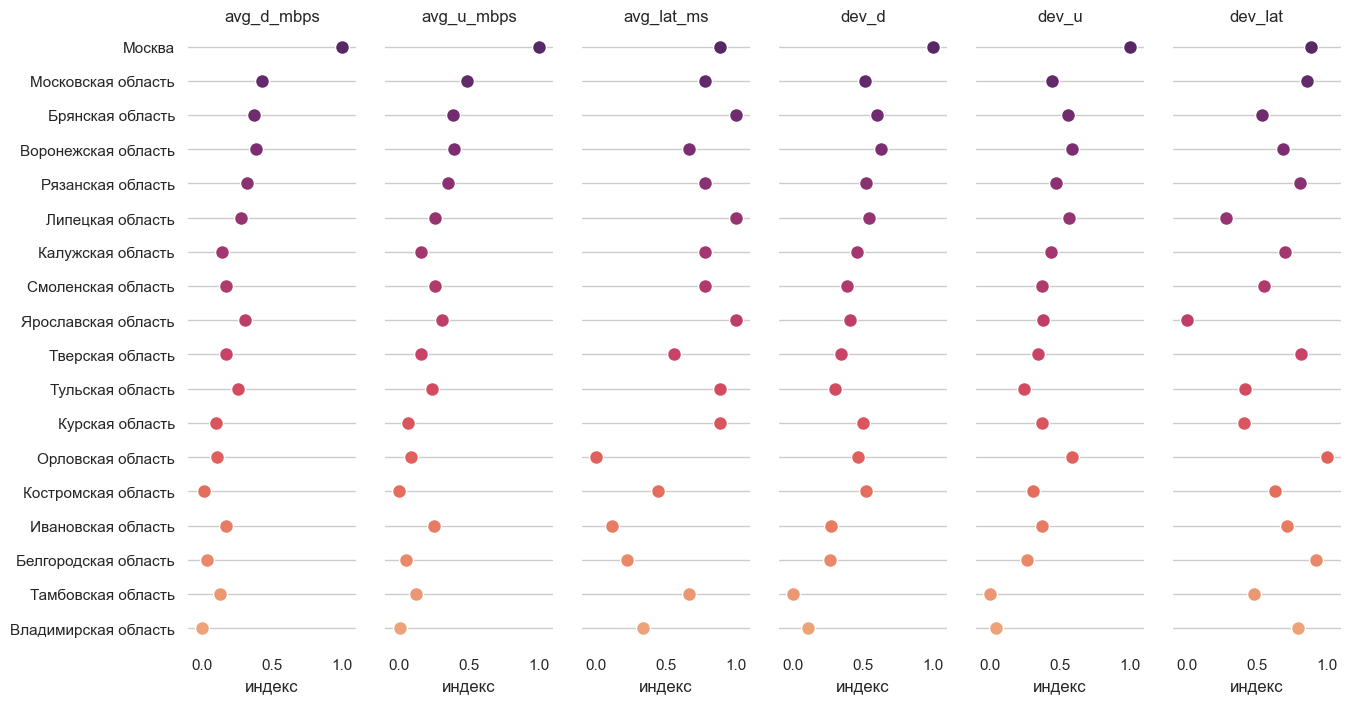

In [208]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the dataset
df_six_indexs = index_df.\
    sort_values(by = 'total_index', ascending = False)\

# Make the PairGrid
g = sns.PairGrid(index_df.sort_values("total_index", ascending=False),
                 x_vars=index_df.columns[-7:-1], y_vars=["region"],
                 height=7, aspect=0.3)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.1), xlabel="индекс", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms', 'dev_d', 'dev_u', 'dev_lat']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

**Вывод:**

 - Средняя скорость скачивания (avg_d_mbps_n): наибольшие значения скорости скачивания имеет Москва. Наименьшие значения во Владимирской и Костромской областях;
 - Средняя скорость загрузки (avg_u_mbps_n): наибольшие значения скорости загрузки имеет Москва. Наименьшие значения во Владимирской и Костромской областях;
 - Cредняя задержка (avg_lat_ms_n): наилушие значения задержки имеет Брянская, Ярославская и Липецкая области. Нихудшие значения в Орловской и Ивановской областях;
 - Равенство скорости скачивания (dev_d_n): наилучшие значения равенства скорости скачивания имеет Москва. Нихудшие значения в Владмирской и Тамбовской областях;
 - Равенство скорости загрузки (dev_u_n): наилучшие значения равенства загрузки имеет Москва. Наихудшие значения в Владимирской и Тамбовской областях;
 - Равенство задержки (dev_lat_n): наилучшие значения равенства задержки имеет Орловская область. Наихудшие значения в Ярославской;

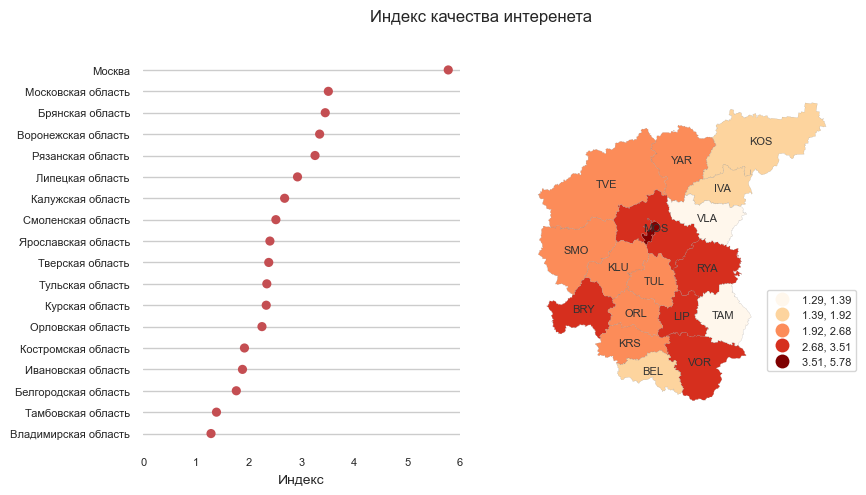

In [204]:
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
sns.despine(bottom=True, left=True)

index_df = index_df.\
    sort_values(by = 'total_index', ascending = False)\

fig.suptitle("Индекс качества интернета", fontsize=12)

sns.pointplot(
    data=index_df, x="total_index", y="region",
    join=False, dodge=.8 - .8 / 3, color = 'r',
    markers="o", scale=.75, errorbar=None, ax = axs[0])

axs[0].set_xlim([0,None])
axs[0].tick_params(labelsize=8)
axs[0].set_xlabel('Индекс', fontsize=10)
axs[0].set_ylabel('', fontsize=10)
axs[0].xaxis.grid(False)
axs[0].yaxis.grid(True)

index_df.plot(column="total_index", 
              scheme='NaturalBreaks', 
              k=5, 
              linewidth=.1,
              edgecolor="grey",
              cmap='OrRd', 
              legend=True,
              legend_kwds={"loc": "upper left", 
                           "bbox_to_anchor": (0.75, 0.4), 
                           "fontsize":"8"},
              ax =axs[1])

index_df\
    .query('label_name != "MOW"')\
    .apply(lambda x: axs[1].annotate(text=x['label_name'], 
                                    xy=x.geometry.centroid.coords[0],
                                    ha='center',
                                    va = 'center',
                                    size = 8,
                                    color='#323232', 
                                    ), axis=1);

axs[1].set_axis_off()
plt.show()

**Вывод:**

 - *Итоговый индекс качества интернета (total_index)*: С большим отрывом от других регионов Москва лидирует в рейтинге (5.78). Наименьшие значения индекса во Владимирской области (1.29);

## Общий вывод:

 - Получена таблица с данными пользователей. Объем датасета 12 полей, 28235 строк;
 - Имеются данные в период с 2020-01 по 2020-04, длительностью 4 месяца;
 - Отфильтровав  данные получили датасет в 27568 строк, сокращение размера на 2,4%;
 - Наибольшие значения скорости скачивания имеет Московский регион (до 157 Мбит/с). Наименьшие значения во Владимирской и Костромской областях (от 54 Мбит/с);
 - Наибольшие значения скорости загрузки имеет Московский регион(до 154 Мбит/с). Наименьшие значения во Владимирской и Костромской областях (от 61 Мбит/с);
 - Наилучшие значения задержки имеет Брянская, Ярославская и Липецкая области (3 мс). Нихудшие значения в Орловской и Ивановской областях (до 12 мс);
 - Неравенство скорости скачивания (dev_d_n): наилучшие значения равенства скорости скачивания имеет Москва. Наихудшие значения в Владимирской и Тамбовской областях;
 - Неравенство скорости загрузки (dev_u_n): наилучшие значения равенства загрузки имеет Москва. Наихудшие значения в Владимирской и Тамбовской областях;
 - Неравенство задержки (dev_lat_n): наилучшие значения равенства задержки имеет Орловская область. Наихудшие значения в Ярославской;
 - **Итоговый индекс качества интернета (total_index)**: С большим отрывом от других регионов Москва лидирует в рейтинге (5.78). Наименьшие значения индекса во Владимирской области (1.29);
